In [91]:
%matplotlib inline
from qiskit import QuantumCircuit
from qiskit.circuit.library import CSwapGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

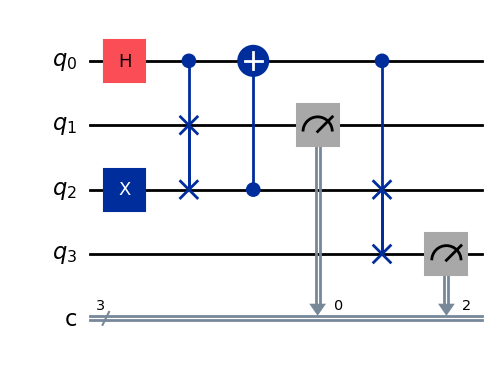

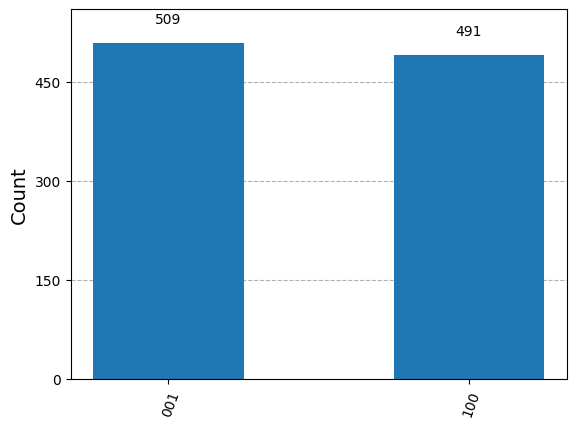

In [93]:

# 1 coin qubit + 3 position qubits, 3 classical bits
qc = QuantumCircuit(4, 3)  # q[0]=coin, q[1:4]=positions


qc.x(2)
qc.h(0)


qc.append(CSwapGate(), [0, 1, 2])
qc.cx(2, 0)
qc.append(CSwapGate(), [0, 2, 3])


qc.measure(1, 0)
qc.measure(3, 2)

# Show circuit diagram
qc.draw('mpl')
plt.show()

# Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)  # Correct usage
result = sim.run(compiled, shots=1000).result()
counts = result.get_counts()
# Show result
plot_histogram(counts)
plt.show()


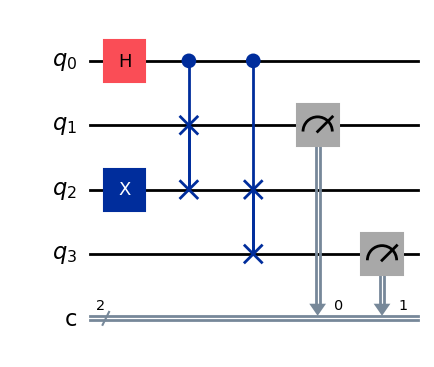

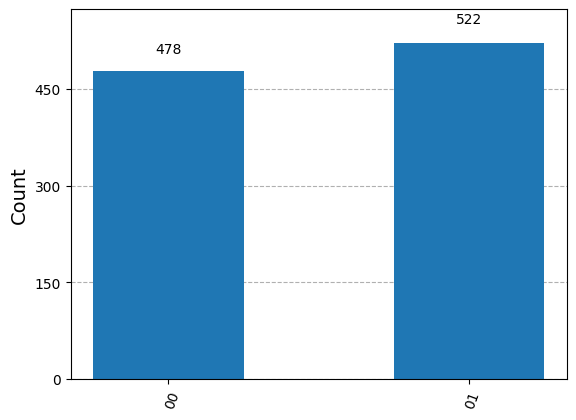

In [94]:


# 1 coin + 3 position qubits (total 4 qubits), 2 classical bits
qc = QuantumCircuit(4, 2)  # q[0]=coin, q[1:4]=positions

qc.x(2)      # Start with particle at middle (q[2])
qc.h(0)      # Coin flip

# Controlled swaps
qc.append(CSwapGate(), [0, 1, 2])  # coin=0 → move left
qc.append(CSwapGate(), [0, 2, 3])  # coin=1 → move right

# Measure only the position qubits (q[1] and q[3])
qc.measure(1, 0)  # Left detector
qc.measure(3, 1)  # Right detector

qc.draw('mpl')
plt.show()

# Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)  # Correct usage
result = sim.run(compiled, shots=1000).result()
counts = result.get_counts()
# Show result
plot_histogram(counts)
plt.show()
